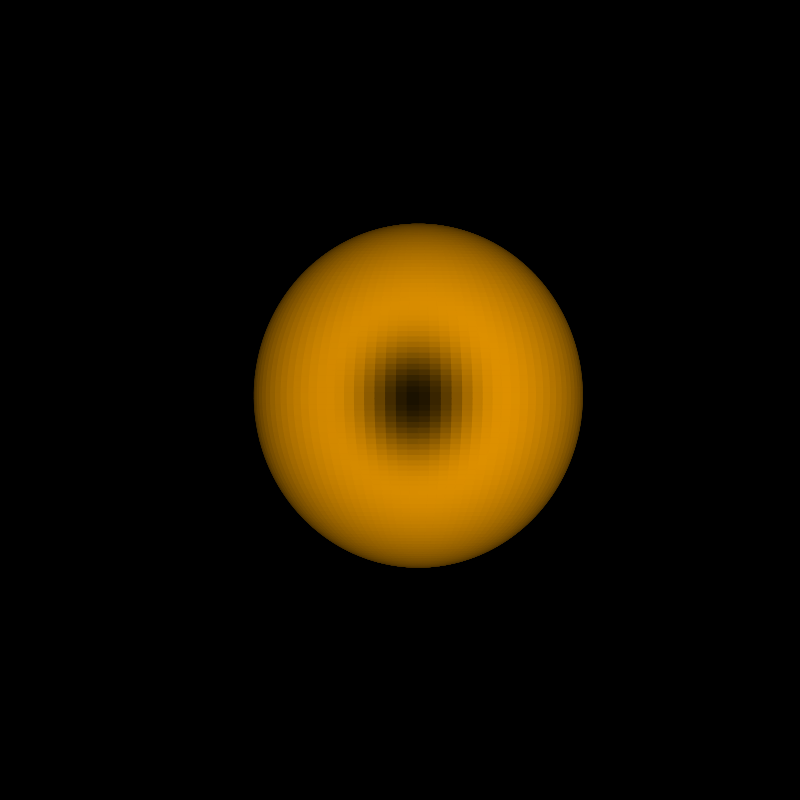

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# Parameters
r = 10
res = 100

theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

base_texture = np.ones((res, res, 4))
base_texture[:, :, 0:3] = [1.0, 0.65, 0]
base_texture[:, :, 3] = 1

spot_theta_deg = 0
spot_phi_deg   = 90
spot_radius_deg = 25

spot_theta_rad = np.deg2rad(spot_theta_deg)
spot_phi_rad   = np.deg2rad(spot_phi_deg)
spot_radius_rad = np.deg2rad(spot_radius_deg)

elev = 0
azim = 0

#converting degree to radians

elev_rad = np.deg2rad(elev)
azim_rad = np.deg2rad(azim) 


#Funnction for the point of view in limb darkening

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)


plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((0.98,1,0.95))
ax.set_axis_off()
ax.view_init(elev=elev, azim=azim, vertical_axis="z") 


# limb darkening depending of the point of view you can play with the elevation and azimut and in theory will look the
#same limb darkening

###Limb Darkening function
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)

def limb_darkening(coeficient):
    for c in range(3):  # R, G, B
        base_texture[:,:, c] *= (1 - u * (1 - mu))
    return base_texture
    
u = 0.8  #------>coefficient of limb darkenin
limb_darkening(u)

##list
fluxes = []
#animation


def animate(i):
    ax.clear()
    ax.set_axis_off()
    ax.set_title(f'', color='white')
    texture = np.copy(base_texture)
    
    # Rotar la mancha
    spot_theta_rad = np.deg2rad(spot_theta_deg) + (2*np.pi*i/120)

    delta_theta = np.abs(theta_mesh - spot_theta_rad)
    delta_theta = np.minimum(delta_theta, 2*np.pi - delta_theta)
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    
    distance_squared = (delta_theta**2 + delta_phi**2)
    sigma_squared = (spot_radius_rad / 2)**2
    spot_mask = np.exp(-distance_squared / (2 * sigma_squared))
    
    texture[:, :, 0:3] *= (1 - 0.9 * spot_mask[:, :, np.newaxis])
    
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)

    brightness = texture[:, :, 0]  # R channel
    visible = mu > 0  # to the observed
    total_flux = np.sum(brightness[visible])
    fluxes.append(total_flux)


    



    return [surf]

ani = animation.FuncAnimation(fig, animate, frames=120, interval=50, blit=False)
ani.save('lightcurve_with_star.gif', writer='ffmpeg', fps=20)  # Puedes ajustar fps si quieres más fluidez

plt.show()



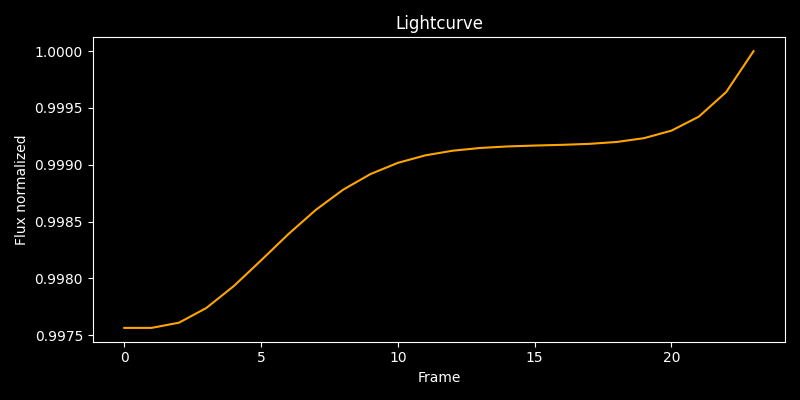

In [2]:
from sklearn.preprocessing import normalize
frames = np.arange(len(fluxes))
# Normalized
fluxes_normalized = normalize([fluxes], norm="max")[0]  


plt.figure(figsize=(8, 4))
plt.plot(frames, fluxes_normalized, color='orange')
plt.title('Lightcurve')
plt.xlabel('Frame')
plt.ylabel('Flux normalized')
plt.tight_layout()
plt.show()

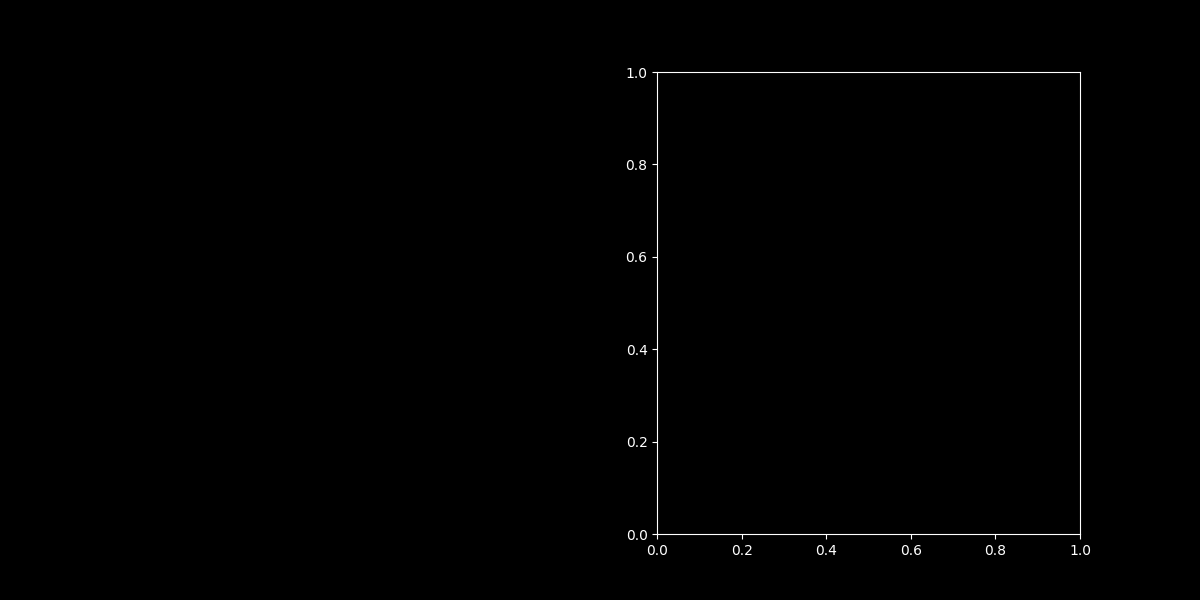

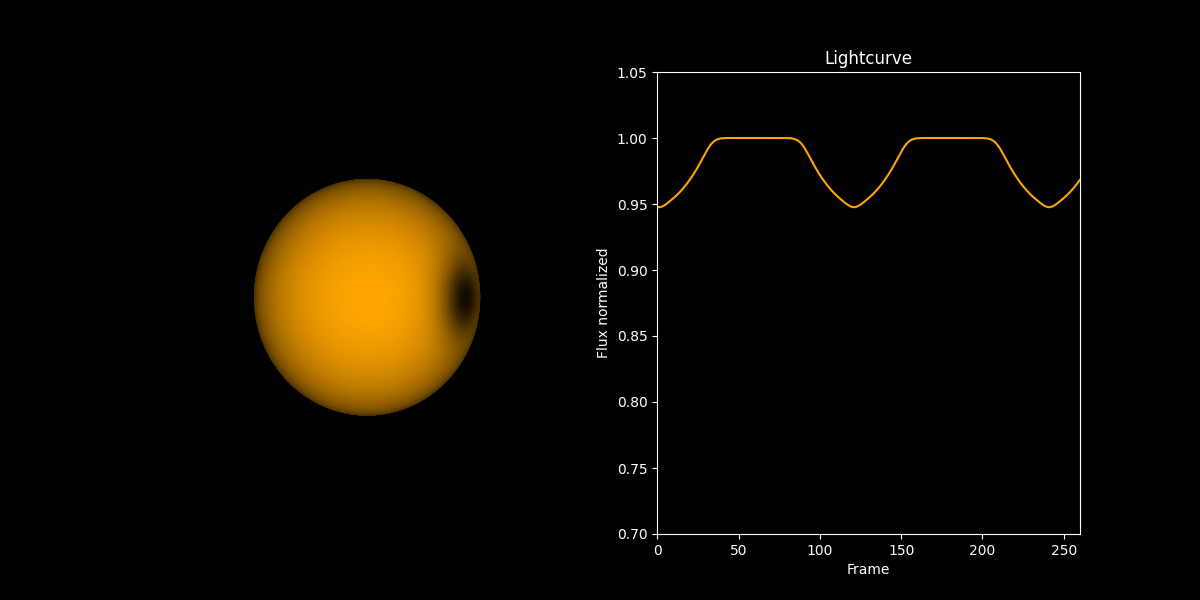

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# Parameters
r = 10###----->>>radii
res = 200
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

base_texture = np.ones((res, res, 4))
base_texture[:, :, 0:3] = [1.0, 0.65, 0]  # naranja
base_texture[:, :, 3] = 1

spot_theta_deg = 0
spot_phi_deg   = 90
spot_radius_deg = 25
spot_phi_rad   = np.deg2rad(spot_phi_deg)
spot_radius_rad = np.deg2rad(spot_radius_deg)

elev = 0
azim = 0

elev_rad = np.deg2rad(elev)
azim_rad = np.deg2rad(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

###Limb Darkening function
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)

def limb_darkening(coeficient):
    for c in range(3):  # R, G, B
        base_texture[:,:, c] *= (1 - u * (1 - mu))
    return base_texture
    
u = 0.8  #------>coefficient of limb darkenin
limb_darkening(u)

# Create the figure and subplots
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 6))
ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98,1,0.95))
ax_sphere.set_axis_off()
ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Frame')
ax_curve.set_ylabel('Flux normalized')
ax_curve.set_xlim(0, 120)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Store fluxes
fluxes = []
def spot(spot_radius_rad,distance_squared):
    return
    

def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

    texture = np.copy(base_texture)
    spot_theta_rad = np.deg2rad(spot_theta_deg) + (2*np.pi*i/120)

    #delta_theta = np.abs(theta_mesh - spot_theta_rad)
    #delta_theta = np.minimum(delta_theta, 2*np.pi - delta_theta)
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))#quitar este si hay problemas
    
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = (delta_theta**2 + delta_phi**2)
    sigma_squared = (spot_radius_rad / 2)**2
    spot_mask = np.exp(-distance_squared / (2 * sigma_squared))

    texture[:, :, 0:3] *= (1 - 0.9 * spot_mask[:, :, np.newaxis])
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)

    # Calcular el flujo
    brightness_rgb = texture[:, :, 0:3]  # R, G, B
    brightness_total = np.mean(brightness_rgb, axis=2)  # promedio por pixel
    visible = mu > 0
    total_flux = np.sum(brightness_total[visible])
    fluxes.append(total_flux)
    
    # brightness = texture[:, :, 0]  # canal rojo
    # visible = mu > 0
    # total_flux = np.sum(brightness[visible])
    # fluxes.append(total_flux)

    # Normalizar y actualizar curva de luz
    fluxes_array = np.array(fluxes)
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes)), fluxes_normalized)
    ax_curve.set_xlim(0, 260)

    return [surf, line_curve]

ani = animation.FuncAnimation(fig, animate, frames=260, interval=60, blit=False)
# Guardar como GIF
ani.save('lightcurve_with_star5.gif', writer='ffmpeg', fps=20)  # Puedes ajustar fps si quieres más fluidez

plt.show()


In [8]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# Parámetros de la esfera
r = 10
res = 200
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# Textura base en escala de grises (blanco puro)
gray_texture = np.ones((res, res))  # intensidad 1 = blanco

# Parámetros de la mancha
spot_theta_deg = 0
spot_phi_deg = 90
spot_radius_deg = 25
spot_phi_rad = np.deg2rad(spot_phi_deg)
spot_radius_rad = np.deg2rad(spot_radius_deg)

# Ángulo de vista (observador)
elev = 0
azim = 0
elev_rad = np.deg2rad(elev)
azim_rad = np.deg2rad(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# # Limb darkening
# mu = (x * v_x + y * v_y + z * v_z) / r
# mu = np.clip(mu, 0, 1)
# u = 0.8  # coeficiente de limb darkening
# gray_texture *= (1 - u * (1 - mu))


mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)
def limb_darkening(coeficient):
    ###Limb Darkening function
    global gray_texture 
    gray_texture *= (1 - u * (1 - mu))
   
    
u = 0.8  #------>coefficient of limb darkenin
limb_darkening(u)


# Figura
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 6))
ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))
ax_sphere.set_axis_off()
ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Días')
ax_curve.set_ylabel('Flux normalizado')
ax_curve.set_xlim(0, 260)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Flujo almacenado
fluxes = []

def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

    # Copia de textura para esta animación
    texture = np.copy(gray_texture)

    # Movimiento de la mancha
    spot_theta_rad = np.deg2rad(spot_theta_deg) + (2*np.pi*i/260)
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    spot_mask = np.exp(-distance_squared / (2 * sigma_squared))

    # Aplicar mancha oscura
    texture *= (1 - 0.9 * spot_mask)

    # Convertir a textura RGBA para graficar
    texture_rgba = np.zeros((res, res, 4))
    texture_rgba[:, :, 0:3] = texture[:, :, np.newaxis]  # RGB igual
    texture_rgba[:, :, 3] = 1  # Alpha

    # Dibujar la superficie
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture_rgba, shade=False)

    # Calcular flujo visible
    visible = mu > 0
    total_flux = np.sum(texture[visible])
    fluxes.append(total_flux)

    # Normalizar e ingresar a la curva
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes)), fluxes_normalized)

    return [surf, line_curve]

# Animación
ani = animation.FuncAnimation(fig, animate, frames=260, interval=60, blit=False)
ani.save('lightcurve_white_star.gif', writer='ffmpeg', fps=20)
plt.show()


UnboundLocalError: local variable 'gray_texture' referenced before assignment